In [7]:
import sys
sys.path.append("../../../") # Where to find utilssphering
import utilssphering
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [8]:
# Read CSV
match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,channel_names,brightfield_z_plane_used,feature_channels_found,sphering,value_95_replicating,Percent_Replicating,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,NaN,1,10,6,...,0.000144,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",True,0.200046,57.777778,20.930233,0.303191,2014937
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,NaN,1,10,6,...,0.000144,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",False,0.420650,35.555556,16.279070,0.307224,2014937
2,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",True,0.268013,62.222222,20.930233,0.401802,2413350
3,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",False,0.338900,47.777778,16.279070,0.411854,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,...,0.000142,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",True,0.205121,66.666667,23.255814,0.363114,2381443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,...,0.000583,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",False,0.628379,20.000000,6.976744,0.772160,489099
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",True,0.139090,56.666667,18.604651,0.193171,452567
359,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",False,0.666818,21.111111,9.302326,0.790813,452567
360,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_40x,Confocal,9,4.0,1,40,6,...,0.080201,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",True,0.193787,53.333333,20.930233,0.234702,116595


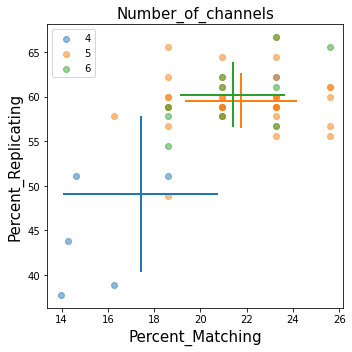

In [14]:
# A 

group = "Number_of_channels"

df_subset = match_rep_df[
    (match_rep_df["sphering"] == True) &
    (~match_rep_df["Batch"].str.contains("siteSub")) 
    ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig,
    ax_=ax
)
utilssphering.group_plot(
    df=df_subset,
    x="Percent_Matching", 
    y="Percent_Replicating",
    group=group,
    fig=fig,
    ax_=ax,
    legend=True,
    alpha=0.5
)

        
fig.savefig("(A)-rep-vs-match-number_of_channels.png", dpi=300)

In [10]:
# B 

# Find channel names from load_data_csvs
def find_channel_names(metadata_df, load_data_path):
    plates = []
    df = metadata_df.copy()
    for root, dirs, files in os.walk(load_data_path):
        for file in files:
            if "load_data_with_illum.csv" in file:
                path = os.path.join(root, file)
                plate = os.path.split(path)[0].split("/")[-1]
                plates.append(plate)
                if plate not in metadata_df["Assay_Plate_Barcode"].values:
                    print("No channel name source found for: ", path, plate)
                columns = pd.read_csv(path).columns.tolist()
                channels = sorted([i.replace("FileName_Orig", "") for i in columns if "FileName_Orig" in i])
                channels = ", ".join(channels)
                # df.loc[df["Assay_Plate_Barcode"] == plate, "channel_names"] = ", ".join(channels)
                df.loc[df["Assay_Plate_Barcode"] == plate, "channel_names"] = channels
    return df

experiment_df = find_channel_names(match_rep_df, "../../../../jump-scope/load_data_csv/")

def search_correlations(metadata_df, profile_path):
    """
    Reads *_normalized_feature_select_negcon_batch.csv.gz
    and performs a function on the dataframe 
    """
    df_list = []
    # metadata_df = metadata_df[~metadata_df["Batch"].str.contains("siteSub")]
    df = metadata_df.copy()
    df = df[~df["Batch"].str.contains("siteSub")]
    for ind, row in metadata_df.iterrows():
        df_path = os.path.join(profile_path, row["Batch"], row["Assay_Plate_Barcode"], f"{row['Assay_Plate_Barcode']}.csv.gz")
        df_path = glob.glob(df_path)[0]
        load_df = pd.read_csv(df_path)
        # cols = [i for i in load_df.columns if ("Golgi" in i and "Actin" in i and "Costes" in i) or 
        #                                         ("Golgi" in i and "DNA" in i and "Costes" in i) or
        #                                         ("Actin" in i and "DNA" in i and "Costes" in i) or
        #                                         ("AGP" in i)
        #                                         ]
        cols = [i for i in load_df.columns if ("Cells" in i and "Costes" in i)]
        # cols = [i for i in load_df.columns if i in ["Actin", "DNA", "ER", "Golgi", "Mito", "RNA"]]
        load_df = load_df[cols]
        # For the masked dataset (which represents one plate), aggregate all well values
        load_df.agg(np.mean)
        # Since the DF was masked by [cols], add back in the Batch, Assay_Plate_Barcode and channel_names, based on the row info
        load_df["Batch"], load_df["Assay_Plate_Barcode"], load_df["channel_names"] = [row["Batch"], row["Assay_Plate_Barcode"], row["channel_names"]]
        df_list.append(load_df)
    out_df = pd.concat(df_list)
    # Once concatenated, aggregate all values based on channel_name grouping
    out_df = out_df.groupby(
                        "channel_names",as_index=False).agg(np.mean)
    return out_df

corr_df = search_correlations(experiment_df, "../../../../jump-scope/profiles/")

# Find a subset of combinations
mask_cols = corr_df.columns[corr_df.columns.str.contains("Costes_Actin|channel_names")]
corr_df = corr_df[mask_cols]

plot_corr_df = corr_df[(corr_df["channel_names"] == "Actin, DNA, ER, Golgi, Mito, RNA")].dropna(axis=1).transpose().reset_index()

plot_corr_df.iloc[1:,:]

No channel name source found for:  ../../../../jump-scope/load_data_csv/2020_11_06_Scope1_MolDev/Plate3_PCO_6ch_1site_10XPA_Crestz/load_data_with_illum.csv Plate3_PCO_6ch_1site_10XPA_Crestz
No channel name source found for:  ../../../../jump-scope/load_data_csv/2020_11_06_Scope1_MolDev/Plate3_PCO_6ch_Adaptive_20XPA/load_data_with_illum.csv Plate3_PCO_6ch_Adaptive_20XPA
No channel name source found for:  ../../../../jump-scope/load_data_csv/2020_11_06_Scope1_MolDev/Plate3_PCO_6ch_1site_10XPA_Crest/load_data_with_illum.csv Plate3_PCO_6ch_1site_10XPA_Crest
No channel name source found for:  ../../../../jump-scope/load_data_csv/2020_11_06_Scope1_MolDev/Plate2-PCO-6ch-1site-10XPA/load_data_with_illum.csv Plate2-PCO-6ch-1site-10XPA
No channel name source found for:  ../../../../jump-scope/load_data_csv/2020_11_16_Scope1_YokogawaUS/BRO0117033_20x/load_data_with_illum.csv BRO0117033_20x
No channel name source found for:  ../../../../jump-scope/load_data_csv/2020_11_16_Scope1_YokogawaUS/BRO0117

,index,3
1,Cells_Correlation_Costes_Actin_DNA,0.336076
2,Cells_Correlation_Costes_Actin_ER,0.605308
3,Cells_Correlation_Costes_Actin_Golgi,0.818547
4,Cells_Correlation_Costes_Actin_Mito,0.557478
5,Cells_Correlation_Costes_Actin_RNA,0.70764


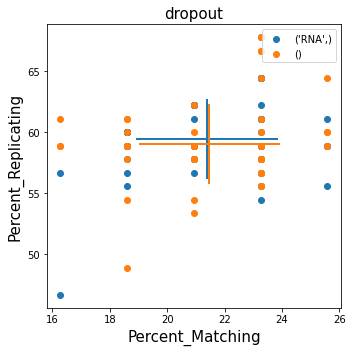

In [15]:
# C
rna_drop_df = pd.read_csv("../../../checkpoints/match_rep_df-RNA-DROP.csv")

group = "dropout"

df_subset = rna_drop_df[
    (rna_drop_df["sphering"] == True) &
    # Drop runs on all profiles, including those that don't even have an RNA channel
    # (not ideal, but saves time re-running)
    (rna_drop_df["channel_names"].str.contains("RNA")) &
    (~rna_drop_df["Batch"].str.contains("siteSub")) 
    ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig,
    ax_=ax
)
utilssphering.group_plot(
    df_subset, 
    "Percent_Matching", 
    "Percent_Replicating", 
    group=group, 
    fig=fig, 
    ax_=ax, 
    legend=True)

fig.savefig("(C)-rep-vs-match-RNA-dropout.png", dpi=300)